# 回帰分析ー連続値をとる目的変数の予測
- 教師あり学習のもう１つの分野である回帰分析を詳しく見ていく。
- 回帰モデルは連続値をとる目的変数を予測するために使用される。
- 例としては、企業の今後数カ月の月間の売上を予測することが挙げられる。

1.データセットの探索と可視化

2.線形回帰モデルを実装するための各種アプローチの考察

3.外れ値に対して頑健な回帰モデルのトレーニング

4.回帰モデルの評価と一般的な問題の診断

5.回帰モデルの非線形データでの学習

# 10.1 単純な線形回帰モデル
- 単変量の線形回帰の目的は、単一の特徴量と連続の応答との関係をモデルとして表現することである。
$$y=w_{0}+w_{1}x$$
- ここでの奥表は、説明変数と目的変数の関係を表す１次式の重みを学習することである。
- 先に定義した1次式を前提とすれば、線形回帰について「サンプル点を通過する直線のうち最も適合するものを見つけ出すこと」として理解できる。
- 最も適合する直線を回帰直線と呼ぶ。
- 回帰直線からサンプル点への縦線はオフセットまたは残渣と呼ばれ、予測の誤差を表す。
- 線形回帰モデルを複数の説明変数に合わせて一般化することも可能である。このプロセスを重回帰と呼ばれる。
$$y = w_{0}x_{0}+w_{1}x_{1}+\ldots+w_{m}x_{m}=\sum^{m}_{i=0}w_{i}x_{i}=\vec{w}^{T}\vec{x}$$

# 10.2 Housingデータセットの探索
- 目的変数として住宅価格の中央値(MEDV)を使用する。
- 13個の説明変数を1つ以上使って目的変数を予測する。

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
                 header=None,sep='\s+')
df.columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


# 10.2.1 データセットの重要な特性を可視化する。
- 探索的データ解析は、機械学習モデルのトレーニングを行う前の、最初の重要なステップとして推奨される。
- 外れ値、データの分布、特料料の間の関係を視覚的に検出する。
- 散布図行列を利用すれば、データセットの特徴量のペアに対する相関関係を１つの平面上で可視化できる。

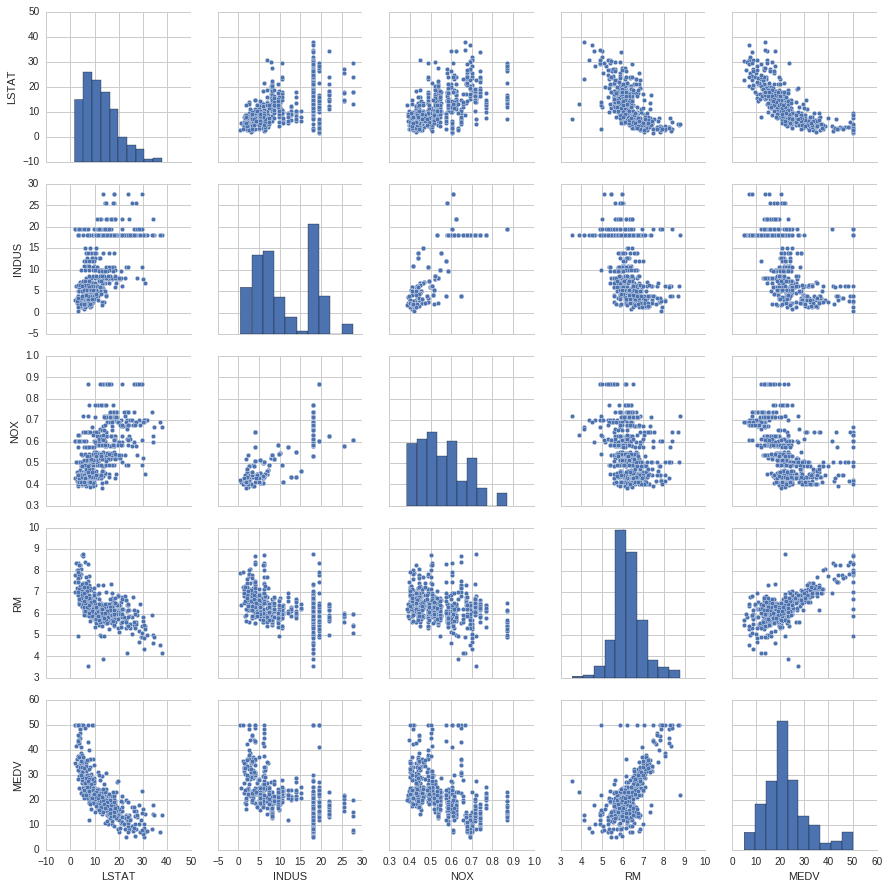

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#グラフのスタイルを指定(whitegridは白背景グリッド、notebookはデフォルトサイズ)
sns.set(style='whitegrid',context='notebook')
cols = ['LSTAT','INDUS','NOX','RM','MEDV']
#変数のペアの関係をプロット:dfはDataFrameオブジェクト、sizeは1面のインチサイズ
sns.pairplot(df[cols],size=2.5)
plt.show()

- データの分布とハズレ値が含まれているかどうかをざっと調べる。
- RM（1戸あたりの平均部屋数）とMEDVの関係は線形であることがわかる。
- MEDVのヒストグラムでは、正規分布に見えるもののハズレ値がいくつか含まれる。

- 特徴量の線形関係を数値化するために、相関行列を作成する。
- 直感的には、相関行列は共分散行列の尺度を取りなおしたバージョンであると考えることができる。実際に、相関行列は標準化されたデータから計算された共分散行列に等しい。
- 相関行列は、ピアソンの積率相関係数を成分とする正方行列である。
- ピアソンの積率相関係数は、特徴量のペアの線形的な従属関係を数値化するものである。

$$r = \frac{\Sigma^{n}_{i=1} [(x^{(i)}-\mu_{x})(y^{(i)}-\mu_{y})]}{\sqrt{\Sigma^{n}_{i=1}(x^{(i)}-\mu_{x})^{2}}\sqrt{\Sigma^{n}_{i=1}(y^{(i)}-\mu_{y})^{2}}} = \frac{\sigma_{xy}}{\sigma_{x}\sigma_{y}}$$

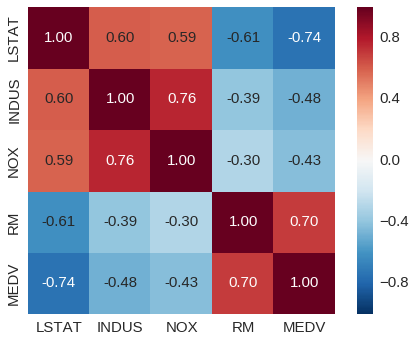

In [3]:
# 5つの特徴量の列を指定してNumpyのcorrcoef関数を呼び出すことで、ピアソンの積率相関係数を計算する。
#snsのheatmap関数を使って相関行列をヒートマプとしてプロットする。
import numpy as np
cm = np.corrcoef(df[cols].values.T) #ピアソンの積率相関係数を計算
sns.set(font_scale=1.5) #全体のスケールとは別にフォントサイズを指定
hm = sns.heatmap(cm, #第一引数の相関係数を基にヒートマップを作成
                cbar=True, #カラーバーの表示
                annot=True, #データ値の表示
                square=True, #各矩形の正方形化（縦と横のサイズを一致させる）
                fmt='.2f', #数値などの表示形式
                annot_kws={'size':15}, #データ値のサイズの設定
                yticklabels=cols, #行の目盛のラベル名
                xticklabels=cols)  #列の目盛のラベル名
plt.show()

- 線形回帰モデルを適合させるにあたって着目すべきは、目的変数であるMEDVとの相関が高い特徴量である。
- MEDVとの相関が最も高いのはLSTATであることがわかる。ただし、散布図行列で示したように,LSTATとMEDVの間に非線形の相関関係があることは明らかである。

# 10.3 最小二乗線形回帰モデルの実装
- 最小二乗法を用いることで、サンプル点に対する縦の距離（残渣または誤差）の二乗の和を最小化するパラメータを推定する。

# 10.3.1 勾配効果法を使って回帰パラメータの回帰を解く
- ADALINEのコスト関数は誤差平方和（SSE）である。これは以下の様に定義でき、最小二乗法のコスト関数に等しい。
$$J(\vec{w}) = \frac{1}{2}\sum^{n}_{i=1}(y^{(i)}-\hat{y}^{(i)})^{2}$$
- 基本的に最小二乗法線形回帰は単位ステップ関数のないADALINEとして解釈できる。

In [4]:
#基本的な線形回帰モデル：第２章のADALINEGDクラスを参照
class LinearRegressionGD(object):
    
    #初期化を実行
    def __init__(self,eta=0.001,n_iter=20):
        self.eta = eta #学習率
        self.n_iter = n_iter #トレーニング回数
        
    #トレーニングを実行
    def fit(self,X,y):
        self.w_ = np.zeros(1 + X.shape[1]) #重みを初期化
        self.cost_ = [] #コスト関数の値を初期化
        for i in range(self.n_iter):
            output = self.net_input(X) #活性化関数の出力を計算
            errors = (y - output) #誤差を計算
            self.w_[1:] += self.eta * X.T.dot(errors) #重みw_{1}以降を更新
            self.w_[0] += self.eta * errors.sum() #重みw_{0}を更新
            cost = (errors**2).sum() / 2.0 #コスト関数を計算
            self.cost_.append(cost) #コスト関数の値を格納
        return self
    
    #総入力を計算
    def net_input(self,X):
        return np.dot(X,self.w_[1:]) + self.w_[0]
    
    #予測値を計算
    def predict(self,X):
        return self.net_input(X)

In [5]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)
lr = LinearRegressionGD()
lr.fit(X_std,y_std)

/home/kyohei/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/kyohei/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


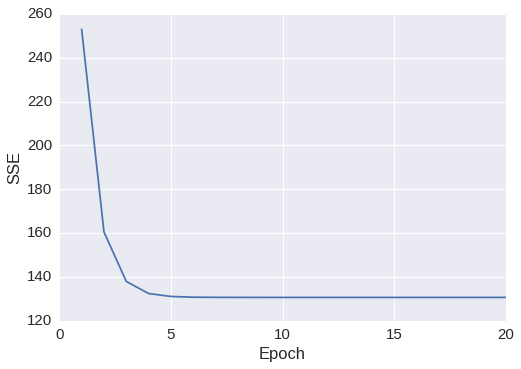

In [6]:
#エポック数とコストの関係を表す折れ線グラフのプロット
plt.plot(range(1,lr.n_iter+1),lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

- 線形回帰の直線がトレーニングデータにどの程度適合しているのかを可視化しする。
- この場合は、トレーニングサンプルの散布図をプロットし、回帰直線を追加する単純なヘルパー関数を定義する。

In [7]:
def lin_regplot(X,y,model):
    plt.scatter(X,y,c='blue')
    plt.plot(X,model.predict(X),color='red')
    return None

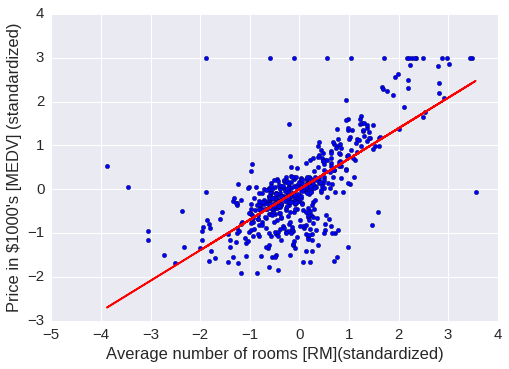

In [8]:
lin_regplot(X_std,y_std,lr)
plt.xlabel('Average number of rooms [RM](standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.show()

- この結果は部屋数が増えると住宅価格も増えるという直感的な結果であるものの、同時に部屋数だけでは住宅価格をうまく説明しきれないケースが多いことも示している。
- 用途によっては、結果変数の予測を基の尺度で報告することが重要になることもある。

In [9]:
#住宅価格を基の尺度に戻す。5部屋の場合の価格を出力
num_rooms_std = sc_x.transform([5.0]) #5部屋を標準化した値を計算
price_std = lr.predict(num_rooms_std)
print("Price in 1000's: %.3f") %sc_y.inverse_transform(price_std)

Price in 1000's: 10.840


/home/kyohei/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


- 標準化された変数を扱っている場合、切片の値は更新する必要はない。標準化されている場合はy軸の切片は0になる。

In [10]:
print('slope: %.3f') %lr.w_[1]
print('intercept : %.3f') %lr.w_[0]

slope: 0.695
intercept : -0.000


# 10.3.2 scikit-learnを使って回帰モデルの係数を推定する。

In [11]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f') %slr.coef_[0]
print('Intercept: %.3f') %slr.intercept_

Slope: 9.102
Intercept: -34.671


- 実行結果からわかるように、scikit-learnのLinearRegressionモデルでは、標準化されていないRM変数とMEDV変数を学習している。
- プロットして、先の勾配降下法の実装と比較してみる。

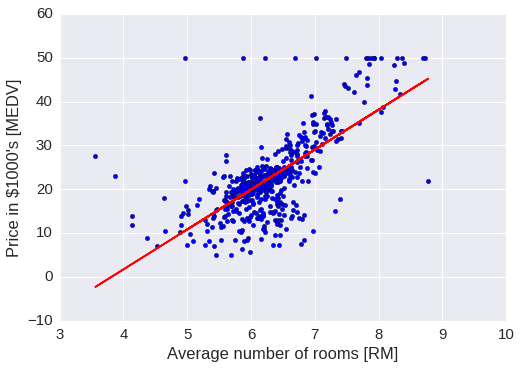

In [12]:
lin_regplot(X,y,slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

# 10.4 RANSACを使ったロバスト回帰モデルの学習
- 線形回帰モデルは外れ値の存在に大きく影響される事がある。
- ※外れ値を検出する統計的方法はいろいろあるが、ここでは取り上げない。
- 外れ値の除去に代わる方法として、RANSACアルゴリズムを使ったロバスト回帰について調べる見る。
- このアルゴリズムは、回帰モデルにデータのサブセット、いわゆる正常値を学習させる。

1.正常値としてランダムな数のサンプルを選択し、モデルを学習させる。

2.学習済みのモデルに対して、その他すべてのデータデータ点を評価し、ユーザ指定の許容範囲となるデータ点を正常値として追加する。

3.すべての正常値を使ってモデルの誤差を推定する。

4.正常値に対する学習済みのモデルの誤差を推定する。

5.モデルの性能がユーザ指定の閾値の条件を満たしている場合、またはイテレーションが規程の回数に達した場合はアルゴリズムを終了する。そうでなければ１に戻る。

In [15]:
from sklearn.linear_model import RANSACRegressor
# ロバスト回帰モデルのクラスをインスタンス化
ransac = RANSACRegressor(LinearRegression(),
                        max_trials=100, #イテレーションの最大数
                        min_samples=50, #ランダムに選択されるサンプルの最小数
                        residual_metric=lambda x:np.sum(np.abs(x),axis=1),#サンプル点の縦の距離の絶対値
                        residual_threshold=5.0, #学習緑線に対する縦の距離が5単位距離内のサンプル点だけが正常値に含まれる。
                        random_state=0)
ransac.fit(X,y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, max_trials=100,
        min_samples=50, random_state=0,
        residual_metric=<function <lambda> at 0x7fcba6df98c0>,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

- デフォルトでは、scikit-learnはMAD推定を使って正常値の閾値を選択する。MADは目的値yの中央絶対偏差である。
- 正常値の適切な閾値の選択は問題に依存するため、RANSACの課題の１つでもある。最近では適切な閾値を自動的に選択する様々な手法が開発されている。
- RANSACモデルを学習させた後は、学習済みの線形回帰モデルから正常値と外れ値を取得し、それらをRANSACモデルによる回帰直線とともにプロットする。

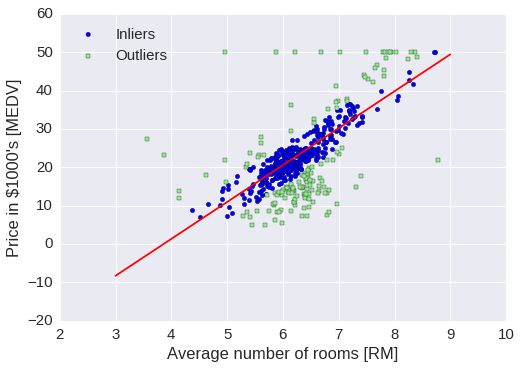

In [16]:
inlier_mask = ransac.inlier_mask_ #正常値を表す真偽値を取得
outlier_mask = np.logical_not(inlier_mask) #外れ値を表す真偽値を取得
line_X = np.arange(3,10,1) #3から9までの整数値を作成
line_y_ransac = ransac.predict(line_X[:,np.newaxis]) #予測値を計算
#正常値をプロット
plt.scatter(X[inlier_mask],y[inlier_mask],c='blue',marker='o',label='Inliers')
#外れ値をプロット
plt.scatter(X[outlier_mask],y[outlier_mask],c='lightgreen',marker='s',label='Outliers')
#予想値をプロット
plt.plot(line_X,line_y_ransac,color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()

- 線形回帰直線が前のRANSACを使用せずに適合させた結果とは少し異なる。

In [17]:
print('Slope: %.3f') %ransac.estimator_.coef_[0]
print('Intercept: %.3f') %ransac.estimator_.intercept_

Slope: 9.621
Intercept: -37.137


# 10.5 線形回帰モデルの性能評価
- データセットをトレーニングとテストに分割し、トレーニングを学習に使用し、テストを未知のデータに対する汎化性能の評価に使用する。
- 個々では単回帰ではなく重回帰モデルをトレーニングする。

In [18]:
from sklearn.cross_validation import train_test_split
X = df.iloc[:,:-1].values
y = df['MEDV'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)
slr = LinearRegression()
slr.fit(X_train,y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

- このモデルでは複数の説明変数を使用するため、線形回帰直線は２次元のグラフとしてプロットできない。
- 残渣プロットは、回帰モデルを診断して非線型正や外れ値を検出し、誤差がランダムに分布しているかどうかをチェックするグラフィカルな解析によく使用される。

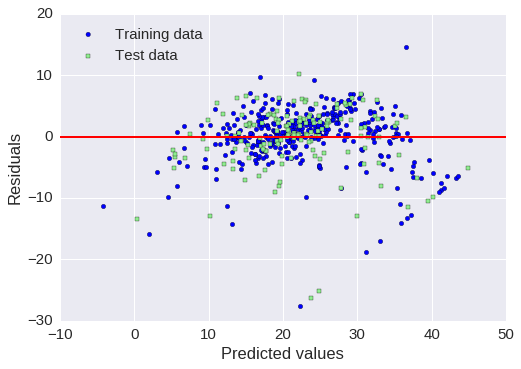

In [19]:
plt.scatter(y_train_pred,y_train_pred - y_train,c='blue',marker='o',label='Training data')
plt.scatter(y_test_pred,y_test_pred - y_test,c='lightgreen',marker='s',label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-10,xmax=50,lw=2,color='red')
plt.xlim([-10,50])
plt.show()

- よい回帰モデルでは、誤差がランダムに分布し、残渣が中央の直線の周りにランダムに散らばる。
- 残渣プロットにパターンが見られる場合は、モデルが何らかの情報を補足できていないことを意味する。そうした情報は残渣に現れてくる。

- モデルの性能を数値化するもう１つの効果的な手法は、平均二乗誤差である。
- 平均二乗誤差は、線形回帰モデルを学習させるために最小化した誤差平方和コスト関数の平均値である。
- MSEは様々な回帰モデルの比較や、グリッドサーチと交差検証を通じたパラメータのチューニングに役立つ。
$$MSE = \frac{1}{n}\sum^{n}_{i=1}(y^{(i)}-\hat{y}^{(i)})^{2}$$

In [20]:
from sklearn.metrics import mean_squared_error
#平均二乗誤差を出力
print('MSE train: %.3f, test:%.3f') %(mean_squared_error(y_train,y_train_pred),
                                     mean_squared_error(y_test,y_test_pred))

MSE train: 19.958, test:27.196


- このモデルによるトレーニングデータの過学習が発生していることを示唆している。
- 場合によっては決定係数を求めるほうが効果的かもしれない。
- 決定係数は、モデルの性能をより効果的に解釈できるようにするための、標準化された平均二乗誤差と考えることができる。
- 決定係数はモデルによって補足された応答の分散の割合を表している。
- 決定係数は平均二乗誤差の尺度を取りなおしたバージョンに過ぎない。

$$R^{2} = 1-\frac{SSE}{SST}$$
$$SST = \sum^{n}_{i=1}(y^{(i)}-\mu_{y})^{2}$$

In [21]:
#R^2（決定係数）のスコアを出力
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f') %(r2_score(y_train,y_train_pred),
                                      (r2_score(y_test,y_test_pred)))

R^2 train: 0.765, test: 0.673


# 10.6 回帰に正則化手法を適用する
- 正則化は過学習の問題に対処する手法の１つであり、モデルの極端なパラメータの重みにペナルティを科すための追加情報を導入する。
- 正則化された線形回帰の最も一般的なアプローチはリッジ回帰、LASSO、ElasticNet法の３つである。
- リッジ回帰はL2ペナルティ付きのモデルである。このモデルの式では、最小二乗コスト関数に対して重みの平方和を足し合わせる。
$$J(\vec{w})_{Ridge} = \sum^{n}_{i=1}(y^{(i)}-\hat{y}^{(i)})^{2} + \lambda\| \vec{w} \|^{2}_{2}$$
$$L2: \, \lambda\| \vec{w} \|^{2}_{2} = \lambda \sum^{m}_{j=1}w^{2}_{j}$$
- ハイパーパラメータ$\lambda$の値を増やすことで、正則化の強さを引き上げ、モデルの重みを減らす。切片項は正則化の対象とはしないことに注意する。
- 疎なモデルを生成するもう１つの方法はLASSOである。正則化の強さによっては、特定の変数の重みが0になることがある。このため、LASSOは教師ありの特徴選択の手法としても役立つ
$$J(\vec{w})_{LASSO} = sum^{n}_{i=1}(y^{(i)}-\hat{y}^{(i)})^{2} + \lambda\| \vec{w} \|_{1}$$
$$L1: \, \lambda\| \vec{w} \|_{1} = \lambda \sum^{m}_{j=1}|w_{j}|$$
- LASSOには制約があり、m>n（サンプルより特徴量が多い場合）の場合、最大値であるnを選択する必要がある。
- リッジ回帰とLASSOの折衷案はElastic Netである。L1ペナルティとL2ペナルティを使用する。
- L1ペナルティは疎性を生成するために使用され、L2ペナルティは選択される変数の個数と言ったLASSOの制約を部分的に克服するために使用される。
$$J(\vec{w})_{ElasticNet} = \sum^{n}_{i=1}(y^{(i)}-\hat{y}^{(i)})^{2} + \lambda_{1}\sum^{m}_{j=1}w^{2}_{j} + \lambda_{2}\sum^{m}_{j=1}|w_{j}|$$

In [22]:
#リッジ回帰モデル
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0) #L2ペナルティ項の影響度合いを表す値

In [23]:
#LASSO
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

In [24]:
#Elastic net
from sklearn.linear_model import ElasticNet
elasticnet = ElasticNet(alpha=1.0,l1_ratio=0.5) #l1_ratioはL1ペナとL2ペナの比率を変更できる。
#例えばl1_ratioを1にすると、L2ペナがなくなる

# 10.7 多項式回帰：線形回帰モデルから曲線を見出す
- 説明変数と目的変数の関係が線形ではない場合、多項式の項が追加された多項式回帰モデルを使用する、という方法がある。
$$y=w_{0}+w_{1}x+w_{2}x^{2}+\ldots+w_{d}x^{d}$$
- 線形回帰の係数wについては線形であるため、やはり重回帰モデルとみなされる。
- 説明変数が１つだけの単純な回帰問題に対して2次の項を追加し、多項式回帰と線形回帰と比較する方法について見てみよう

In [25]:
#1.多項式の2次の項を追加する。
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0,270.0,294.0,320.0,342.0,368.0,396.0,446.0,480.0,586.0])[:,np.newaxis]
y = np.array([236.4,234.4,252.8,298.6,314.2,342.2,360.8,368.0,391.2,390.8])
#線形回帰（最小二乗法）モデルのクラスをインスタンス化
lr = LinearRegression()
pr = LinearRegression()
#2次の多項式特徴量のクラスをインスタンス化
quadratic = PolynomialFeatures(degree=2)
# データに適合させ、データを変換
X_quad = quadratic.fit_transform(X)

In [26]:
#2.比較を可能にするために、単純な線形回帰モデルを学習させる
#データに適合させる
lr.fit(X,y)
#np.newaxisで列ベクトルにする
X_fit = np.arange(256,600,1)[:,np.newaxis]
#予測値を計算
y_lin_fit = lr.predict(X_fit)

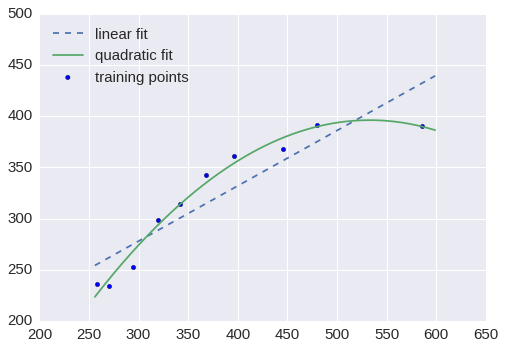

In [27]:
#3.多項式回帰のために、変換された特徴量で複数の回帰モデルを学習させる。
#データに適合させる
pr.fit(X_quad,y)
#2次式でyの値を計算
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))
#散布図、線形回帰モデル、多項式回帰モデルの結果をプロット
plt.scatter(X,y,label='training points')
plt.plot(X_fit,y_lin_fit,label='linear fit',linestyle='--')
plt.plot(X_fit,y_quad_fit,label='quadratic fit')
plt.legend(loc='upper left')
plt.show()

- 結果のグラフでは、目的変数と説明変数の関係について、多項式回帰のほうが線形回帰よりもはるかにうまく補足していることがわかる。

In [28]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f,quadratic: %.3f') %(mean_squared_error(y,y_lin_pred),
                                                    mean_squared_error(y,y_quad_pred))
print('Training R^2 linear: %.3f, quadratic: %.3f') %(r2_score(y,y_lin_pred),r2_score(y,y_quad_pred))


Training MSE linear: 569.780,quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


# 10.7.1 Housingデータセットで非線形関係をモデリングする。

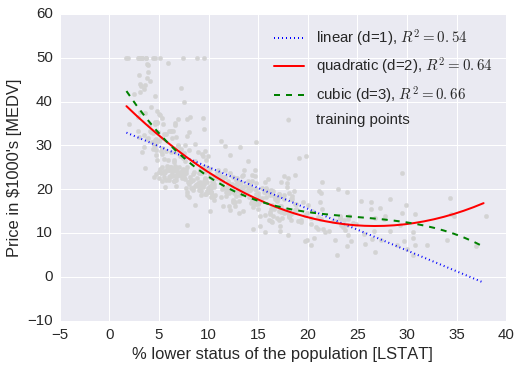

In [30]:
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()

# 多項式の特徴量を生成
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

#線形回帰モデルの学習
X_fit = np.arange(X.min(),X.max(),1)[:,np.newaxis]
regr = regr.fit(X,y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y,regr.predict(X))

#2次の多項式回帰モデルの学習
regr = regr.fit(X_quad,y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y,regr.predict(X_quad))

#3次の多項式回帰モデルの学習
regr = regr.fit(X_cubic,y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y,regr.predict(X_cubic))

#各種モデルの結果をプロット
plt.scatter(X,y,label='training points',color='lightgray')
plt.plot(X_fit,y_lin_fit,label='linear (d=1), $R^2=%.2f$' %linear_r2,color='blue',lw=2,linestyle=':')
plt.plot(X_fit,y_quad_fit,label='quadratic (d=2), $R^2=%.2f$' %quadratic_r2,color='red',lw=2,linestyle='-')
plt.plot(X_fit,y_cubic_fit,label='cubic (d=3), $R^2=%.2f$' %cubic_r2,color='green',lw=2,linestyle='--')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')
plt.show()

- 3次元の多項式回帰モデルの決定係数が最大である。
- ただし、多項式特徴量を追加すればするほどモデルの複雑さが増すことになるため、過学習の可能性が高まることに注意しなければならない。
- また、非線形関係をモデリングするにあたって、多項式の特徴量は必ずしも最良の選択であるとは限らない。
- 例えば、MEDVとLSTATの散布図を見てみると、LSTAT変数の対数とMEDV変数の兵法により、線形回帰モデルの学習に適した線形特徴空間に対して、データを射影できるように思える。

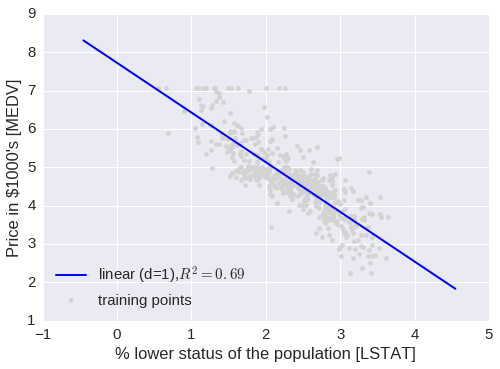

In [33]:
# 特徴量を変換
X_log = np.log(X)
y_sqrt = np.sqrt(y)

#特徴量への適合
X_fit = np.arange(X_log.min()-1,X_log.max()+1,1)[:,np.newaxis]
regr = regr.fit(X_log,y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt,regr.predict(X_log))

#射影したデータを使って学習結果をプロット
plt.scatter(X_log,y_sqrt,label='training points',color='lightgray')
plt.plot(X_fit,y_lin_fit,label='linear (d=1),$R^2=%.2f$' %linear_r2,color='blue',lw=2)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='lower left')
plt.show()

- 結果として、先のどの多項式特徴量変換よりもデータをうまく学習しているように思える。（$R^{2}=0.69$）

# 10.7.2 ランダムフォレストを使って非線形関係に対処する。
- ランダムフォレスト回帰は、ここまでの回帰モデルとは概念的に異なっている。
- グローバルな線形回帰モデルや多項式回帰モデルとは対照的に、区分線形関数の和として考えることができる。
- 決定木アルゴリズムを使って入力空間をより「管理しやすい」小さな領域に分割する。

# 決定木回帰
- 決定木アルゴリズムの利点は、非線形データを扱う場合に特徴量を変換する必要が一切ないことだ。
- 回帰に決定木を使用するには、ノードtの不純指標であるエントロピーを平均二乗誤差で置き換える。
$$I(t)=MSE(t)=\frac{1}{N_{t}}\sum_{i\in D_{t}}(y^{(i)}-\hat{y}^{(i)})^{2}$$
- ここで、$N_{t}$はノードtのトレーニングサンプルの個数、$D_{t}$はノードtのトレーニングサブセット、$y^{(i)}$は真の目的地、$\hat{y}^{(i)}$は予測された目的値（サンプルの平均）である。
$$\hat{y}_{t}=\frac{1}{N}\sum_{i\in D_{t}}y^{(i)}$$
- 決定木回帰のコンテキストでは、MSEはよく「分割後のノード分散」と呼ばれる。
- 分割条件がよく「分散現象」と呼ばれるのはそのためだ。

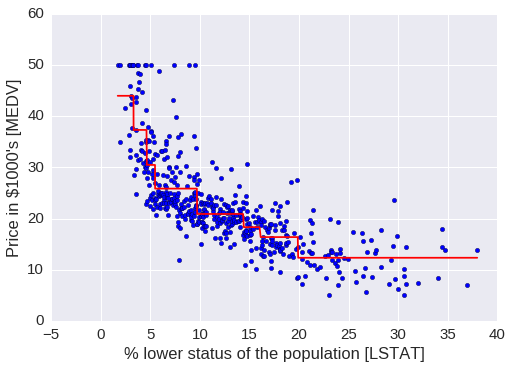

In [49]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
#決定木回帰モデルのクラスをインスタンス化：max_depthで決定木の深さを指定
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
#argsortはソート後のインデックスを返し、flattenは１次元の配列を返す。
sort_idx = X.flatten().argsort()
#10.3.1項で定義したlin_regplot関数により、散布図と回帰直線を作成
lin_regplot(X[sort_idx],y[sort_idx],tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

- 結果のグラフからわかるように、決定木はデータの一般的な傾向を補足している。
- このモデルには、予測値は連続ではなく微分できない（連続性も微分可能性も有していない）という成約がある。
- 更に、決定木の深さとして、過学習または学習不足に陥ることのない適切な値を慎重に選択する必要もある。

# ランダムフォレスト回帰
- ランダムフォレストには、データセットの外れ値にあまり影響を受けず、パラメータのチューニングをそれほど要求しないという利点もある。
- ランダムフォレストのパラメータのうち、一般に実験が必要となるのは、アンサンブルの決定木の個数だけである。
- 分類用のアルゴリズムとの唯一の違いは、個々の決定木の成長に平均二乗誤差の条件を使用することである。
- 予測される目的変数はすべての決定木の予測を平均して計算される。

In [51]:
X = df.iloc[:,:-1].values
y = df['MEDV'].values
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=1)

from sklearn.ensemble import RandomForestRegressor
# ランダムフォレスト回帰のクラスをインスタンス化
forest = RandomForestRegressor(n_estimators=1000,criterion='mse',random_state=1,n_jobs=-1)
forest.fit(X_train,y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
# MSE（平均二乗誤差）を出力
print('MSE train: %.3f, test: %.3f') %(mean_squared_error(y_train,y_train_pred),
                                       mean_squared_error(y_test,y_test_pred))
print('R^2 train: %.3f, test: %.3f') %(r2_score(y_train,y_train_pred),
                                      r2_score(y_test,y_test_pred))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


- 残念ながらランダムフォレストはトレーニングデータを過学習する傾向にあることがわかる。
- 一方で目的変数と説明変数の関係は依然としてうまく説明できている。

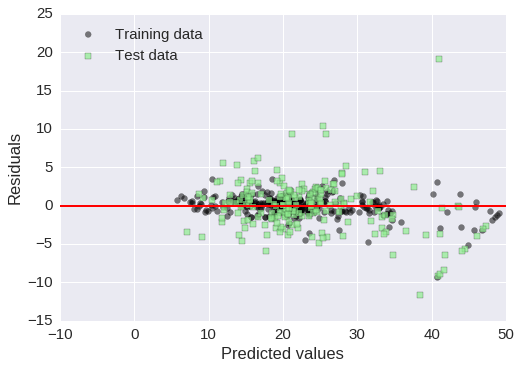

In [52]:
#予測値と残渣をプロット
plt.scatter(y_train_pred,#x値
           y_train_pred - y_train,#y値
           c='black',#プロットの色
           marker='o',#マーカーの種類
           s=35,#マーカーのサイズ
           alpha=0.5,#透過度
           label='Training data') #ラベルの文字

plt.scatter(y_test_pred,
           y_test_pred - y_test,
           c='lightgreen',
           marker='s',
           s=35,
           alpha=0.7,
           label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-10,xmax=50,lw=2,color='red')
plt.xlim([-10,50])
plt.show()

- 決定係数によって要約されているように、このモデルはテストデータよりもトレーニングデータのほうと適合することがわかる。
- 残渣は原点の周囲に完全にランダムに分布しているようには見えない。これは、このモデルが情報を完全に補足できていないことを示唆している。
- ただし、先と比較すると大きな改善である。
- svmも非線形回帰にも使用できる。。。